# Evaluating synthetic yeast promoters using Polygraph

In [1]:
import numpy as np
import pandas as pd
import plotnine as p9

import polygraph.input, polygraph.embedding, polygraph.motifs, polygraph.models, polygraph.sequence, polygraph.utils, polygraph.visualize, polygraph.stats
pd.set_option('display.precision', 2)
%matplotlib inline

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


## Read data

The input file should be a tab or comma separated file with two columns. The first column contains the sequence and the second contains the group. The `read_seqs` function will assign a unique ID to each sequence.

In [2]:
seqs = polygraph.input.read_seqs('yeast_seqs.txt')
seqs.head()

,SeqID,Sequence,Group
0,seq_0,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTCTGTACGTTA...,native_high
1,seq_1,CATCGACTTATTTTTTTTTTTTGATGAAATTTTTCAGATTTTACAA...,native_high
2,seq_2,GCCTCTTATTTTTTTTTTTTTCGATTTTTGGCCCACAGGTCATATT...,native_high
3,seq_3,GATGAGTGAAAAATCGTAATGAGTCAGCAAATCACTGTGTACGTTA...,native_high
4,seq_4,AGAGCGACGCAAACAGCGCGCAGACTCTACGGGTAATAGACTCACA...,native_high


This dataset contains the sequences of selected native yeast promoters as well as 50 random sequences and 50 synthetic promoters each generated by evolution and gradient (Ledidi) methods starting from the random sequences.

In [3]:
print(seqs.Group.value_counts())

Group
native_high    50
native_low     50
random         50
evolution      50
gradient       50
Name: count, dtype: int64


# 1. Evaluate sequence content

## 1.1 GC content

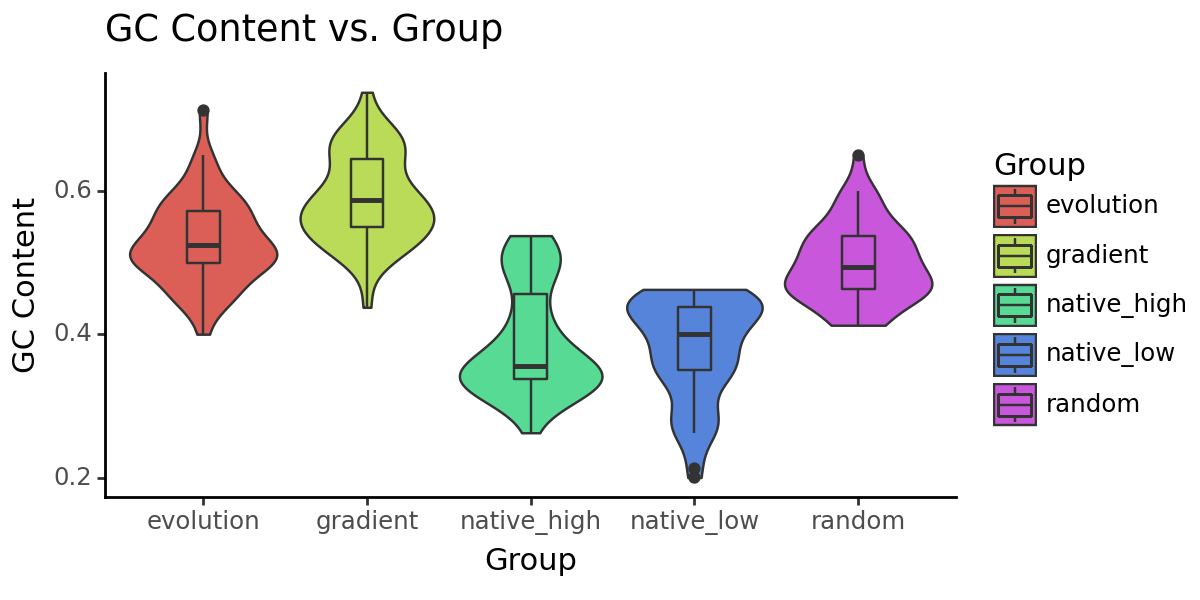

<Figure Size: (600 x 300)>

In [4]:
seqs['GC Content'] = polygraph.sequence.gc(seqs)
polygraph.visualize.boxplot(seqs, value_col='GC Content') + p9.theme(figure_size=(6,3))

In [5]:
polygraph.stats.kruskal_dunn(data=seqs, val_col="GC Content")

{'Kruskal': 2.6802086812745613e-33,
 'Dunn':              evolution  gradient  native_high  native_low    random
 evolution     1.00e+00  3.98e-02     5.08e-11    1.12e-12  8.74e-01
 gradient      3.98e-02  1.00e+00     1.33e-21    6.62e-24  4.45e-05
 native_high   5.08e-11  1.33e-21     1.00e+00    1.00e+00  2.06e-06
 native_low    1.12e-12  6.62e-24     1.00e+00    1.00e+00  1.08e-07
 random        8.74e-01  4.45e-05     2.06e-06    1.08e-07  1.00e+00}

## 1.2 length distribution

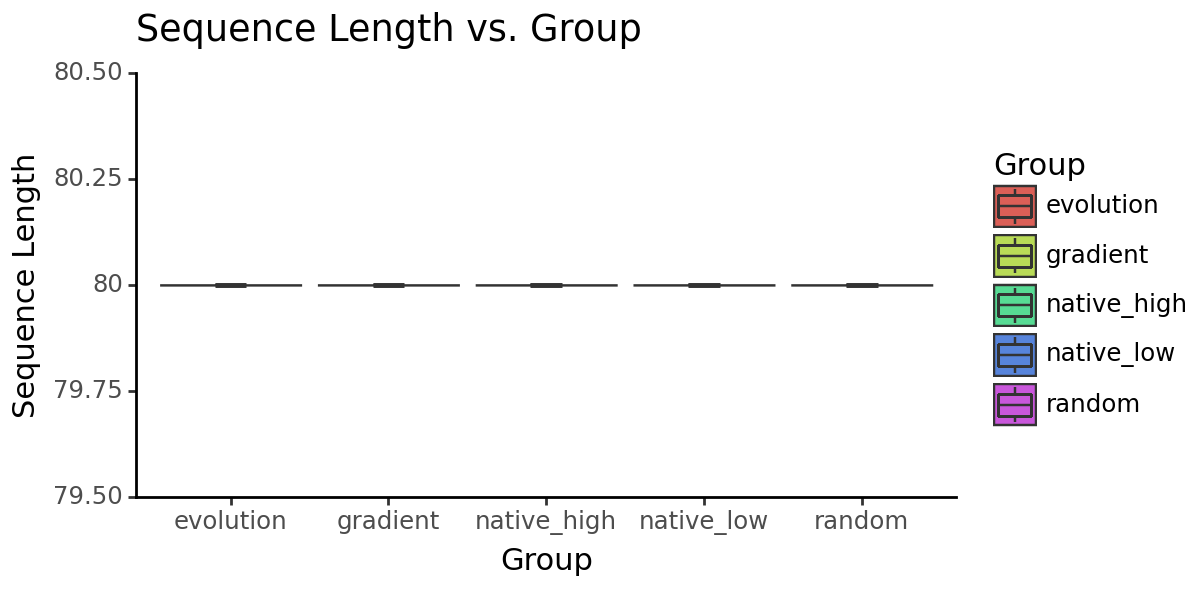

<Figure Size: (600 x 300)>

In [6]:
seqs['Sequence Length'] = seqs.Sequence.apply(len)
polygraph.visualize.boxplot(seqs, value_col='Sequence Length') + p9.theme(figure_size=(6,3))

## 1.3 k-mer content

In [7]:
%%time
kmers = polygraph.sequence.kmer_frequencies(seqs.Sequence.tolist(), k=5, normalize=True)

CPU times: user 477 ms, sys: 27.6 ms, total: 505 ms
Wall time: 498 ms


In [8]:
%%time
emb = polygraph.embedding.embedding_analysis(kmers, seqs, reference_group='native_high', use_pca=True)

Creating AnnData object
PCA


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Fraction of variance explained:  [0.07 0.04 0.04 0.03 0.03 0.03 0.02 0.02 0.02 0.02 0.02 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01]
Fraction of total variance explained:  0.6727464259481488
UMAP
Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 1min 10s, sys: 3.19 s, total: 1min 13s
Wall time: 7.4 s


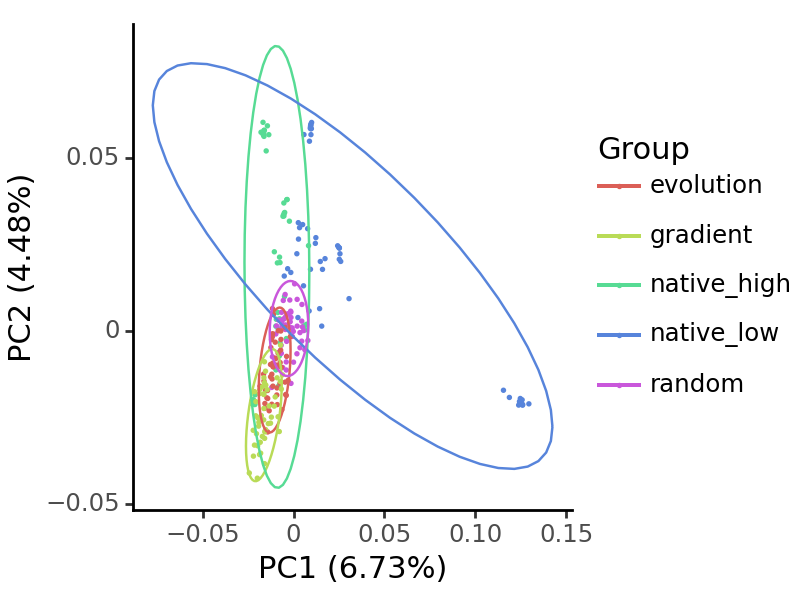

<Figure Size: (400 x 300)>

In [9]:
polygraph.visualize.pca_plot(emb, show_ellipse=True) + p9.theme(figure_size=(4,3))

In [10]:
# Differential k-mer abundance

print("Number of differential k-mers compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential k-mers")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

Number of differential k-mers compared to reference
Group
native_low    23
gradient      13
random         7
evolution      3
Name: count, dtype: int64

Top Differential k-mers
           Group  value  score      padj  log2FC
1021    gradient  GCGCG   6.60  4.17e-08    2.80
2042  native_low  TTTTT  -6.20  5.60e-07  -23.47
3063      random  TTTTT  -5.89  4.01e-06   -4.47
1022    gradient  CGCGC   5.76  4.21e-06    2.55
2043  native_low  TTTTC  -5.52  1.71e-05   -5.14
2044  native_low  ATGAT   5.22  6.02e-05    3.52
1023    gradient  AATGA  -5.00  1.97e-04  -23.10
1024    gradient  CGCGT   4.92  2.18e-04    3.01
1026    gradient  CGCGG   4.65  5.56e-04   23.18
1025    gradient  TGAAA  -4.65  5.56e-04  -23.06


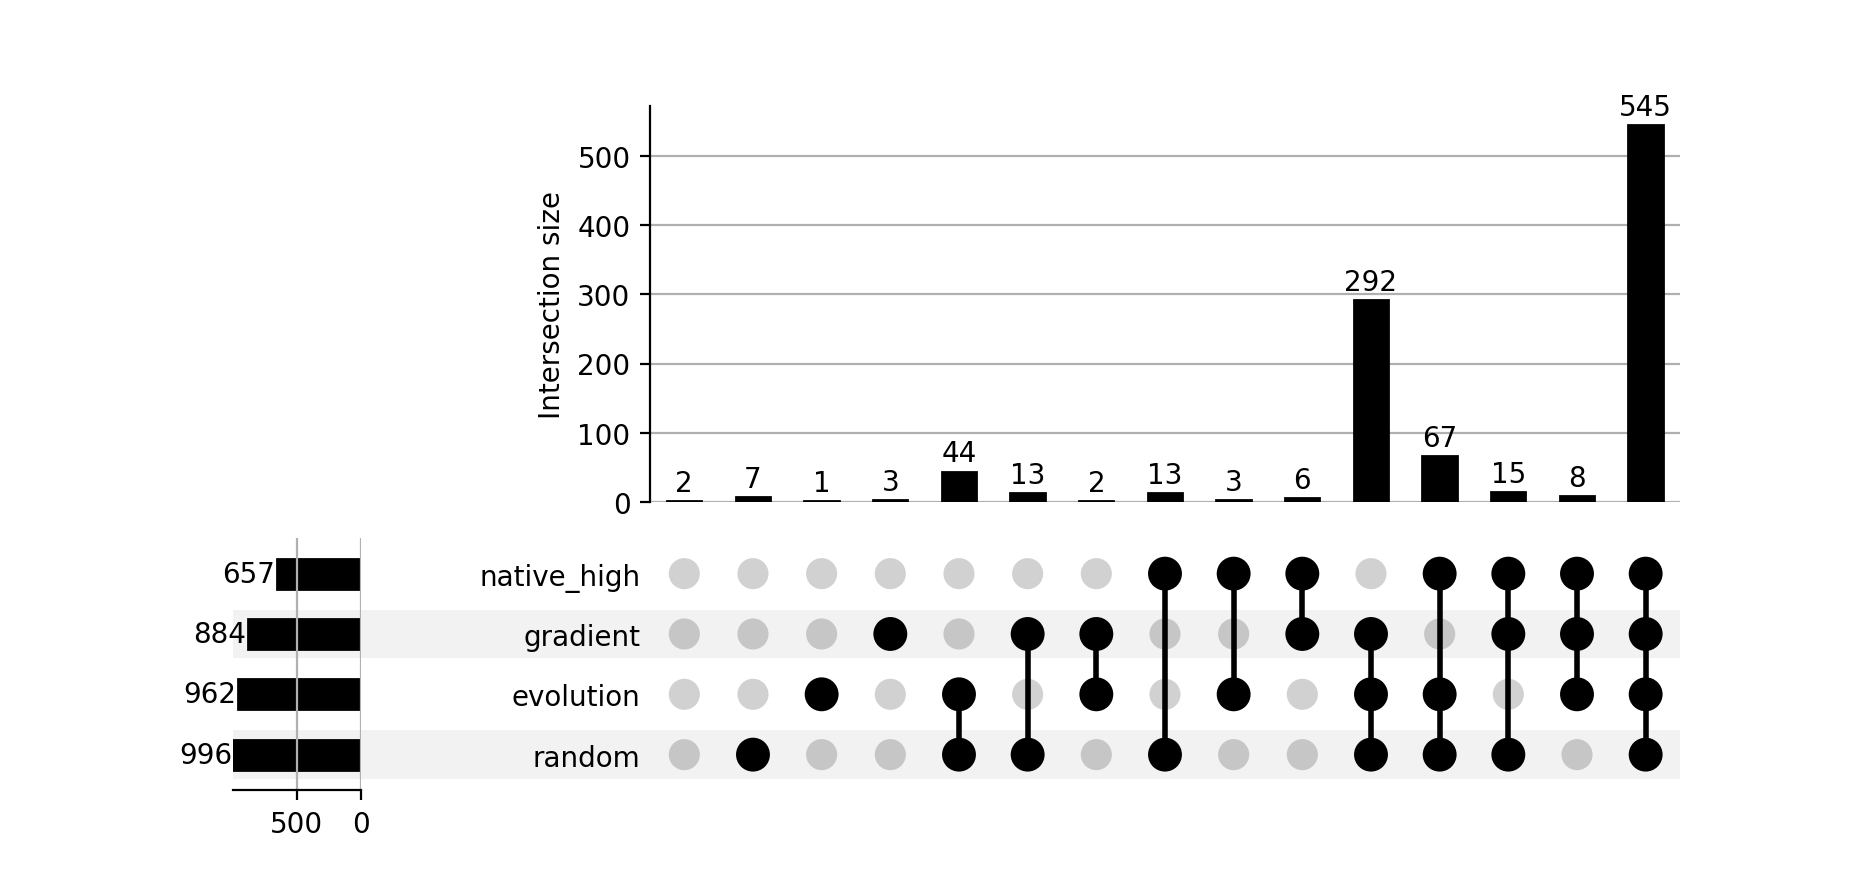

In [11]:
# kmer occurrence
polygraph.visualize.upset_plot(emb[emb.obs.Group!='native_low'])

Fraction of sequences by 1-NN group
one_nn_group  evolution  gradient  native_high  native_low  random
Group                                                             
evolution          0.00      0.04         0.00        0.00    0.96
gradient           0.82      0.10         0.00        0.00    0.08
native_high        0.00      0.00         0.96        0.04    0.00
native_low         0.00      0.00         0.00        0.98    0.02
random             1.00      0.00         0.00        0.00    0.00

p-values for proportion of sequences with native nearest neighbor
            group_prop  ref_prop      pval      padj
Group                                               
native_low         0.0      0.96  2.63e-26  2.63e-26
random             0.0      0.96  2.63e-26  2.63e-26
evolution          0.0      0.96  2.63e-26  2.63e-26
gradient           0.0      0.96  2.63e-26  2.63e-26


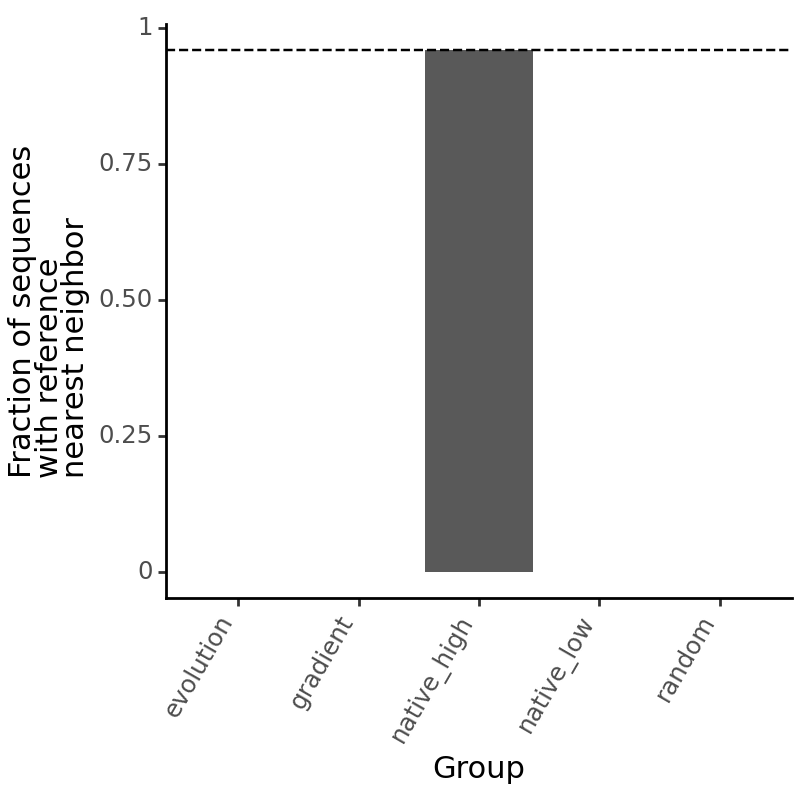

<Figure Size: (400 x 400)>

In [12]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native_high") + p9.theme(figure_size=(4,4))

p-values for distance to closest reference
{'Kruskal': 5.87447378520593e-32, 'Dunn':              evolution  gradient  native_high  native_low    random
evolution     1.00e+00  1.00e+00     2.48e-11    5.72e-06  1.00e+00
gradient      1.00e+00  1.00e+00     9.07e-08    3.91e-09  1.37e-01
native_high   2.48e-11  9.07e-08     1.00e+00    3.35e-32  2.18e-15
native_low    5.72e-06  3.91e-09     3.35e-32    1.00e+00  1.49e-03
random        1.00e+00  1.37e-01     2.18e-15    1.49e-03  1.00e+00}


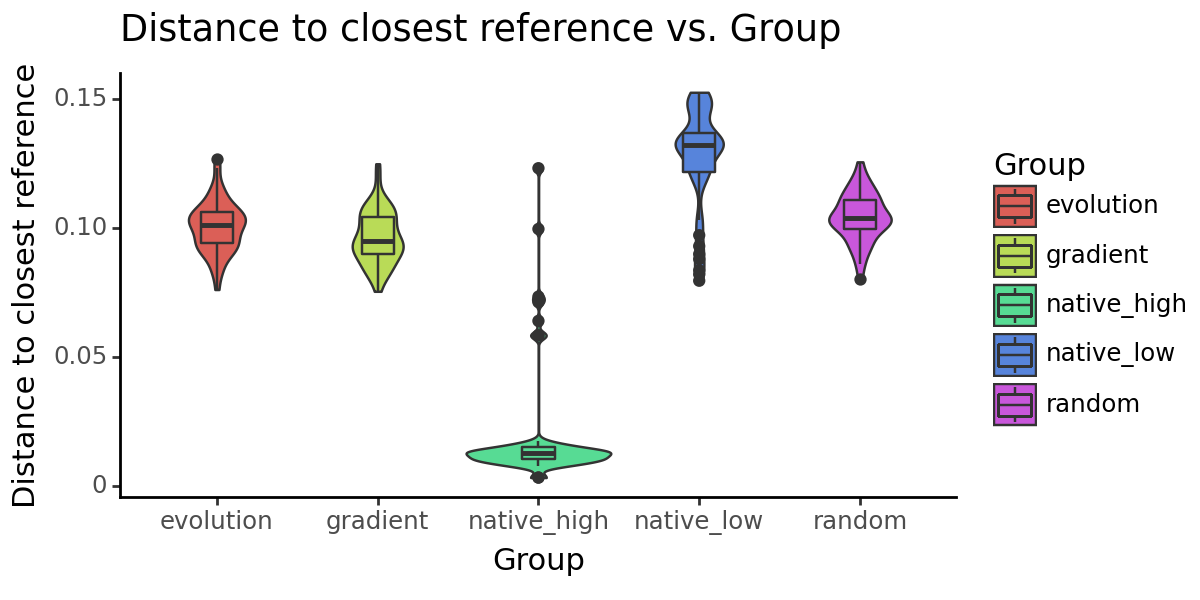

<Figure Size: (600 x 300)>

In [13]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))

p-values for KNN diversity
{'Kruskal': 7.297512880047943e-20, 'Dunn':              evolution  gradient  native_high  native_low    random
evolution     1.00e+00  1.37e-11     1.15e-06    1.39e-13  1.00e+00
gradient      1.37e-11  1.00e+00     7.40e-01    1.00e+00  6.11e-08
native_high   1.15e-06  7.40e-01     1.00e+00    1.66e-01  5.65e-04
native_low    1.39e-13  1.00e+00     1.66e-01    1.00e+00  1.33e-09
random        1.00e+00  6.11e-08     5.65e-04    1.33e-09  1.00e+00}


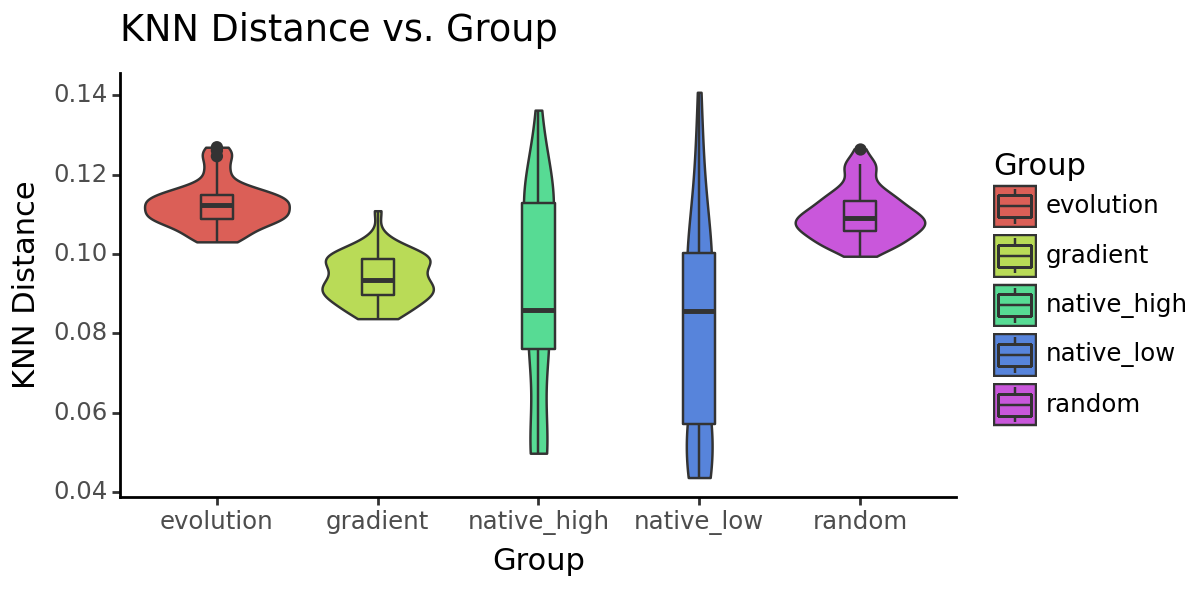

<Figure Size: (600 x 300)>

In [14]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

## 2. Motif content

In [15]:
meme_file = polygraph.input.download_jaspar("fungi")

--2024-01-24 20:10:13--  https://jaspar.elixir.no/download/data/2024/CORE/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt
Resolving jaspar.elixir.no (jaspar.elixir.no)... 158.39.48.179, 2001:700:2:8200::26fc
Connecting to jaspar.elixir.no (jaspar.elixir.no)|158.39.48.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 79182 (77K) [text/plain]
Saving to: ‘/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt.1’

     0K .......... .......... .......... .......... .......... 64%  152K 0s
    50K .......... .......... .......                         100%  277M=0.3s

2024-01-24 20:10:16 (235 KB/s) - ‘/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt.1’ saved [79182/79182]



In [19]:
%%time
sites = polygraph.motifs.scan(seqs, '/opt/conda/lib/python3.8/site-packages/polygraph/resources/jaspar/JASPAR2024_CORE_fungi_non-redundant_pfms_meme.txt')
sites.head()

Read 178 motifs from file.
CPU times: user 2.45 s, sys: 3.44 ms, total: 2.45 s
Wall time: 2.45 s


,MotifID,SeqID,start,end,strand,Group
0,ARG80,seq_241,6,11,+,gradient
1,ARG80,seq_241,16,21,+,gradient
2,ASG1,seq_241,72,67,-,gradient
3,ASG1,seq_241,69,74,+,gradient
4,ASH1,seq_241,72,63,-,gradient


In [20]:
counts = polygraph.motifs.motif_frequencies(sites, seqs=seqs, normalize=True)
counts.iloc[:5, :5]

MotifID,ABF1,ABF2,ACE2,ADR1,AFT1
SeqID,,,,,
seq_0,0.03,0.0,0.0,0.00,0.00
seq_1,0.00,0.0,0.0,0.00,0.00
seq_10,0.01,0.0,0.0,0.00,0.00
seq_100,0.00,0.0,0.0,0.01,0.01
seq_101,0.00,0.0,0.0,0.00,0.00


In [21]:
%%time
emb = polygraph.embedding.embedding_analysis(counts, seqs, reference_group='native_high')

Creating AnnData object
PCA
Fraction of variance explained:  [0.3  0.06 0.05 0.04 0.04 0.03 0.03 0.02 0.02 0.02 0.02 0.02 0.02 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.9072847758135552
UMAP


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference
CPU times: user 35.4 s, sys: 1.58 s, total: 37 s
Wall time: 1.1 s


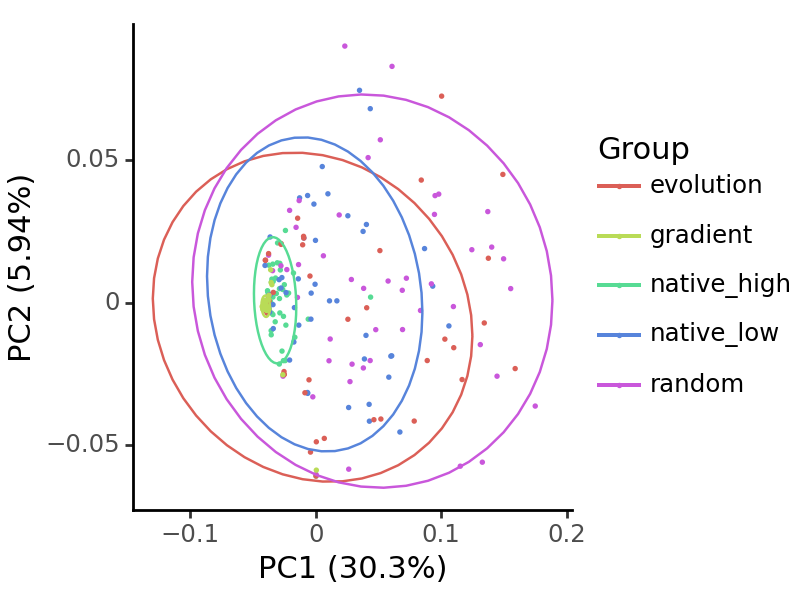

<Figure Size: (400 x 300)>

In [22]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(4,3))

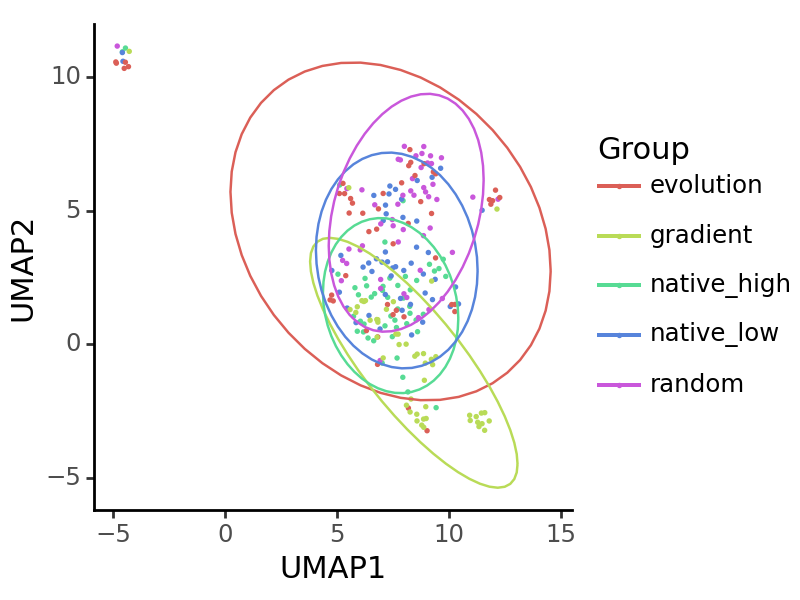

<Figure Size: (400 x 300)>

In [23]:
polygraph.visualize.umap_plot(emb) + p9.theme(figure_size=(4,3))

In [24]:
# Differential motif abundance

print("Number of differential motifs compared to reference")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].Group.value_counts())

print("")

print("Top Differential motifs")
print(emb.uns["DE_test"][emb.uns["DE_test"].padj < .05].sort_values('padj').head(10))

Number of differential motifs compared to reference
Group
random        12
native_low     4
Name: count, dtype: int64

Top Differential motifs
          Group  value  score      padj  log2FC
525      random  RSC30   6.32  4.53e-08    4.48
526      random   RSC3   5.49  3.43e-06    3.58
527      random   SUT1   5.30  6.58e-06    4.34
528      random   TEA1   4.91  3.95e-05    2.81
529      random   MBP1   4.71  8.74e-05    2.49
530      random   PUT3   4.14  9.51e-04    3.56
531      random   RTG3   4.12  9.51e-04    3.05
350  native_low  RSC30   4.48  1.28e-03    3.25
532      random  DAL81   3.86  2.47e-03    3.24
533      random   UGA3   3.52  8.18e-03    2.30


Fraction of sequences by 1-NN group
one_nn_group  evolution  gradient  native_high  native_low  random
Group                                                             
evolution          0.36      0.14         0.12        0.18    0.20
gradient           0.10      0.78         0.08        0.00    0.04
native_high        0.12      0.42         0.26        0.16    0.04
native_low         0.10      0.06         0.50        0.14    0.20
random             0.12      0.06         0.16        0.50    0.16

p-values for proportion of sequences with native nearest neighbor
            group_prop  ref_prop  pval  padj
Group                                       
native_low        0.50      0.26  0.02  0.06
random            0.16      0.26  0.33  0.33
evolution         0.12      0.26  0.12  0.17
gradient          0.08      0.26  0.03  0.06


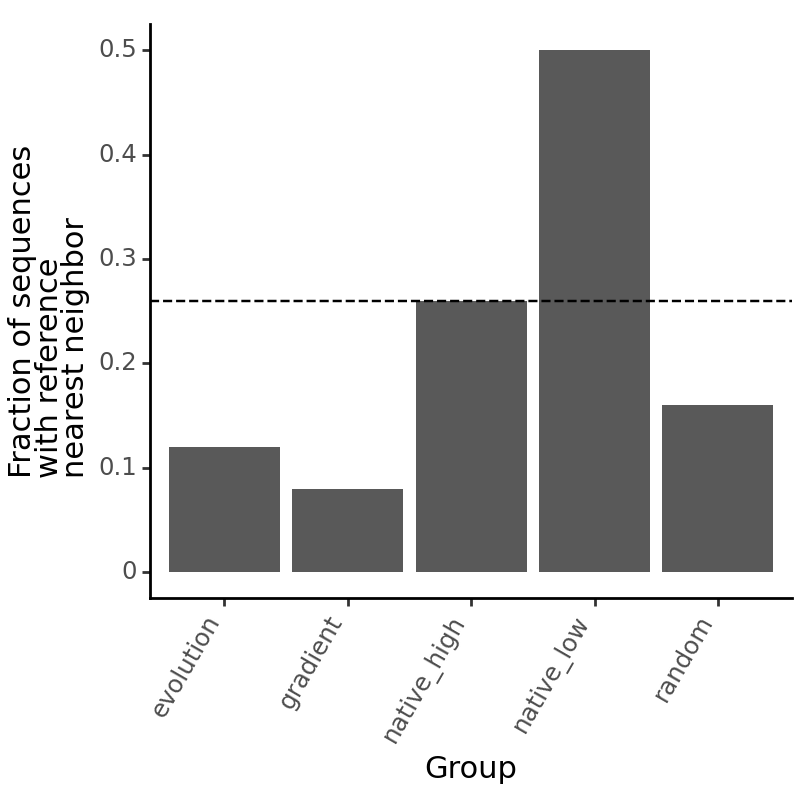

<Figure Size: (400 x 400)>

In [25]:
# 1-NN statistics
print("Fraction of sequences by 1-NN group")
print(emb.uns["1NN_group_probs"])

print("")

print("p-values for proportion of sequences with native nearest neighbor")
print(emb.uns["1NN_ref_prop_test"])

# Plot
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native_high") + p9.theme(figure_size=(4,4))

p-values for distance to closest reference
{'Kruskal': 7.916904502615033e-16, 'Dunn':              evolution  gradient  native_high  native_low    random
evolution     1.00e+00  6.64e-05     3.70e-01    1.00e+00  1.67e-03
gradient      6.64e-05  1.00e+00     1.55e-01    1.74e-06  1.35e-15
native_high   3.70e-01  1.55e-01     1.00e+00    5.02e-02  4.92e-08
native_low    1.00e+00  1.74e-06     5.02e-02    1.00e+00  2.34e-02
random        1.67e-03  1.35e-15     4.92e-08    2.34e-02  1.00e+00}


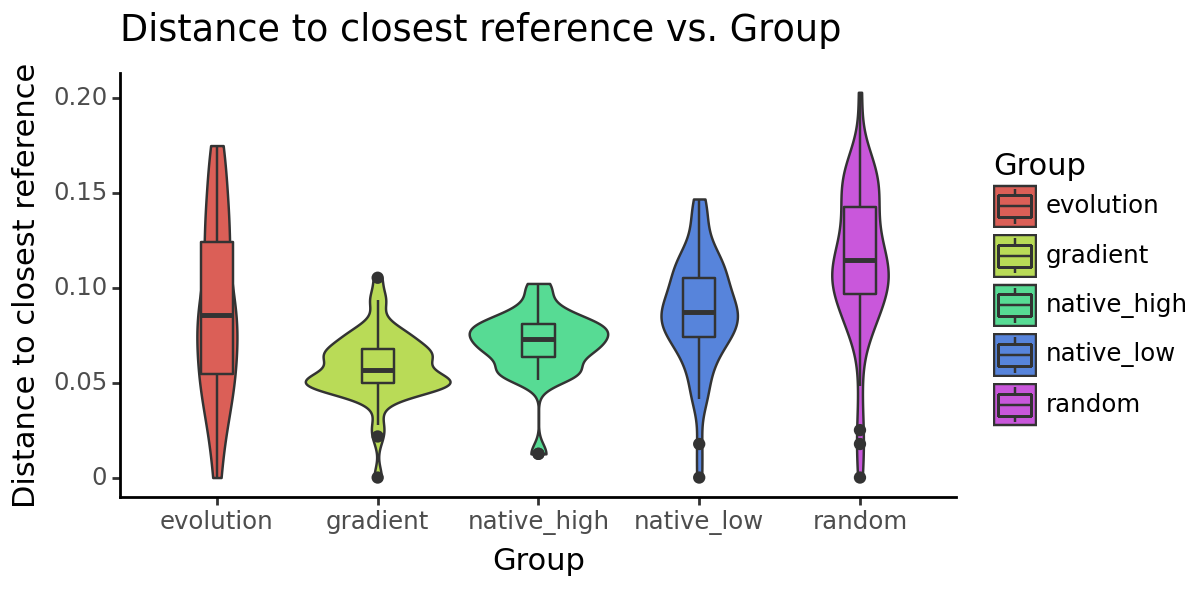

<Figure Size: (600 x 300)>

In [26]:
#Distance to reference
print("p-values for distance to closest reference")
print(emb.uns["ref_dist_test"])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6,3))

p-values for KNN diversity
{'Kruskal': 2.3410175458880582e-32, 'Dunn':              evolution  gradient  native_high  native_low    random
evolution     1.00e+00  6.24e-12     2.41e-03    1.00e+00  3.82e-04
gradient      6.24e-12  1.00e+00     4.26e-03    8.15e-16  1.13e-28
native_high   2.41e-03  4.26e-03     1.00e+00    1.54e-05  6.71e-14
native_low    1.00e+00  8.15e-16     1.54e-05    1.00e+00  2.84e-02
random        3.82e-04  1.13e-28     6.71e-14    2.84e-02  1.00e+00}


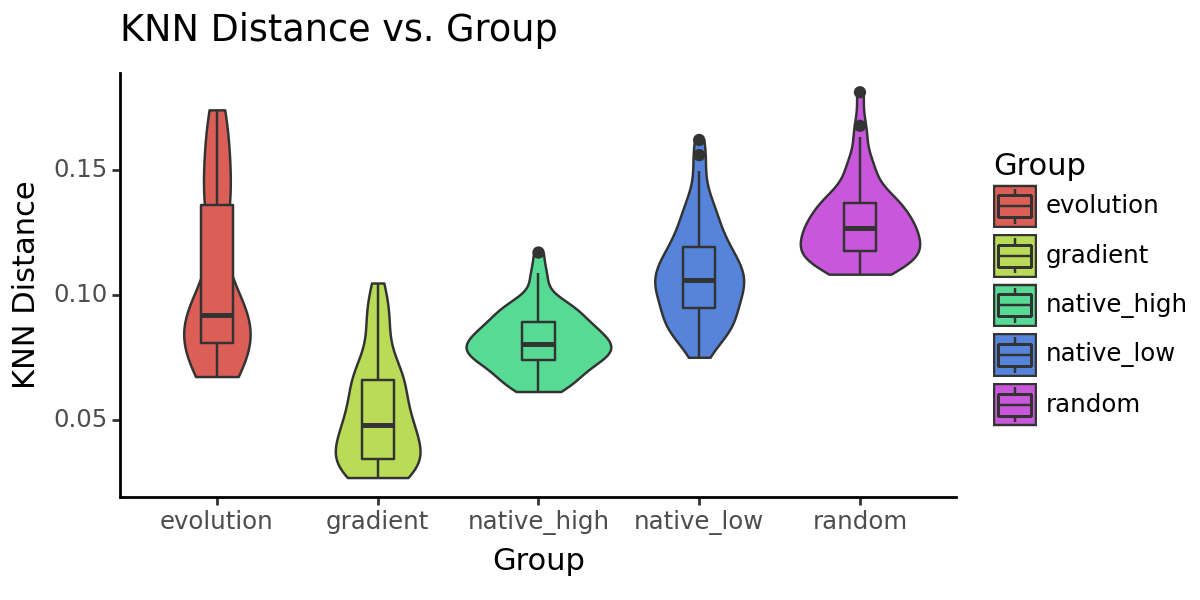

<Figure Size: (600 x 300)>

In [27]:
# KNN distance (diversity metric)
print("p-values for KNN diversity")
print(emb.uns["knn_dist_test"])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

## 2.2 motif combinations

In [28]:
%%time
motif_combinations = polygraph.motifs.motif_combinations(
    counts, seqs, reference_group='native_high', min_group_freq=10)

Listing motif combinations
Making count matrix
Filtering
Selected 2866 combinations
Significance testing
CPU times: user 10.4 s, sys: 2.79 ms, total: 10.4 s
Wall time: 10.4 s


In [29]:
motif_combinations.sort_values('padj').head(10)

,Group,group_prop,ref_prop,pval,padj,combination
3,gradient,0.86,0.02,2.03e-19,7.18e-16,"(RSC3, RSC30)"
15,gradient,0.78,0.00,8.29e-18,1.47e-14,"(RSC3, MBP1)"
7,gradient,0.80,0.02,5.13e-17,6.05e-14,"(TEA1, RSC30)"
19,gradient,0.78,0.02,2.73e-16,2.42e-13,"(SUT1, RSC30)"
39,gradient,0.70,0.00,4.11e-15,1.82e-12,"(RTG3, RSC30)"
35,gradient,0.70,0.00,4.11e-15,1.82e-12,"(TEA1, DAL81)"
55,gradient,0.70,0.00,4.11e-15,1.82e-12,"(DAL82, RSC30)"
51,gradient,0.70,0.00,4.11e-15,1.82e-12,"(TEA1, MBP1)"
71,gradient,0.64,0.00,2.52e-13,8.12e-11,"(SUT1, MBP1)"
75,gradient,0.64,0.00,2.52e-13,8.12e-11,"(RSC3, DAL81)"


In [30]:
# Are there any significant motif combinations where neither individual motif is significant?
sig_motifs = emb.uns["DE_test"][emb.uns["DE_test"].padj < .01].value.tolist()
sig_combs = motif_combinations[motif_combinations['padj'] < .01]
sig_combs = sig_combs[sig_combs.combination.apply(lambda c: (c[0] not in sig_motifs) and (c[1] not in sig_motifs))]

In [31]:
sig_combs[sig_combs.Group=='evolution']

,Group,group_prop,ref_prop,pval,padj,combination
346,evolution,0.44,0.08,6.49e-05,5.84e-04,"(PDR3, nit-4)"
354,evolution,0.30,0.02,1.75e-04,1.22e-03,"(MBP1::SWI6, DAL82)"
370,evolution,0.24,0.00,2.31e-04,1.31e-03,"(CHA4, DAL82)"
406,evolution,0.30,0.00,1.78e-05,1.96e-04,"(SWI4, DAL82)"
630,evolution,0.06,0.38,1.79e-04,1.25e-03,"(STB3, YPR015C)"
...,...,...,...,...,...,...
3390,evolution,0.00,0.22,5.27e-04,2.24e-03,"(GCN4, YPR015C)"
3414,evolution,0.00,0.22,5.27e-04,2.24e-03,"(GCN4, INO4)"
3426,evolution,0.22,0.00,5.27e-04,2.24e-03,"(SWI4, STB3)"
3442,evolution,0.20,0.00,1.19e-03,4.73e-03,"(SWI4, URC2)"


## 2.3 motif positions

In [45]:
# Select the TF motif most enriched in synthetic sequences
df = emb.uns['DE_test']
df[df.Group=='evolution'].sort_values('padj').head()

,Group,value,score,padj,log2FC
0,evolution,SUT1,3.19,0.19,3.71
1,evolution,RTG3,3.03,0.19,2.59
2,evolution,RSC3,2.94,0.19,2.85
9,evolution,PUT3,2.54,0.20,3.01
7,evolution,TEA1,2.56,0.20,2.29


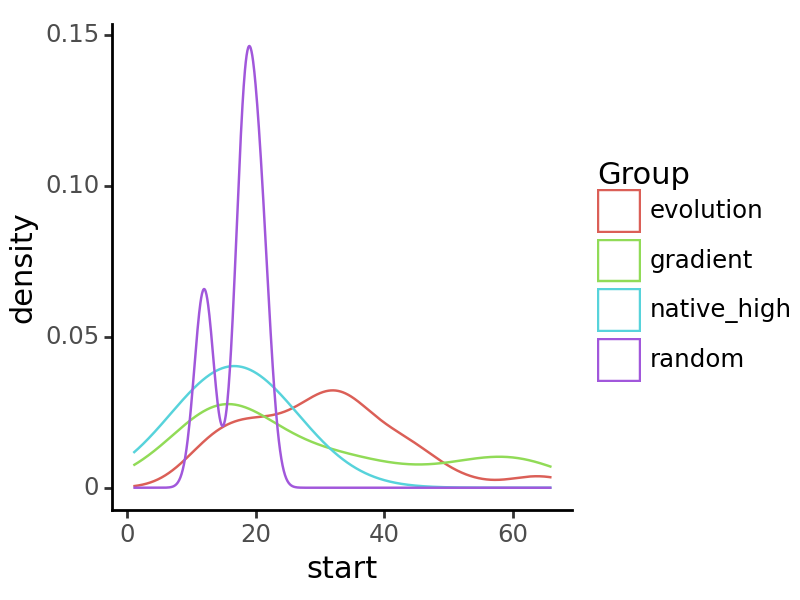

<Figure Size: (400 x 300)>

In [43]:
polygraph.visualize.densityplot(sites[sites.MotifID=='SUT1'], value_col='start') + p9.theme(figure_size=(4,3))

In [44]:
polygraph.stats.kruskal_dunn(sites[sites.MotifID=='SUT1'], val_col='start')

{'Kruskal': 0.023464939920650765,
 'Dunn':              evolution  gradient  native_high  random
 evolution         1.00      0.27         0.05    0.68
 gradient          0.27      1.00         0.47    1.00
 native_high       0.05      0.47         1.00    1.00
 random            0.68      1.00         1.00    1.00}

## 2.4 NMF

In [46]:
%%time
W, H, p = polygraph.motifs.nmf(counts, seqs, reference_group='native_high', n_components=10)

CPU times: user 20.2 s, sys: 885 ms, total: 21.1 s
Wall time: 213 ms


In [47]:
p[p.padj < .001]

,group,pval,padj,factor
0,native_low,2.53e-05,1.69e-04,factor_0
1,random,3.32e-11,1.33e-09,factor_0
3,gradient,1.27e-04,6.34e-04,factor_1
1,random,5.89e-08,1.18e-06,factor_3
3,gradient,1.94e-05,1.69e-04,factor_3
2,evolution,9.98e-05,5.70e-04,factor_4
3,gradient,1.09e-06,1.45e-05,factor_6
3,gradient,2.22e-05,1.69e-04,factor_7


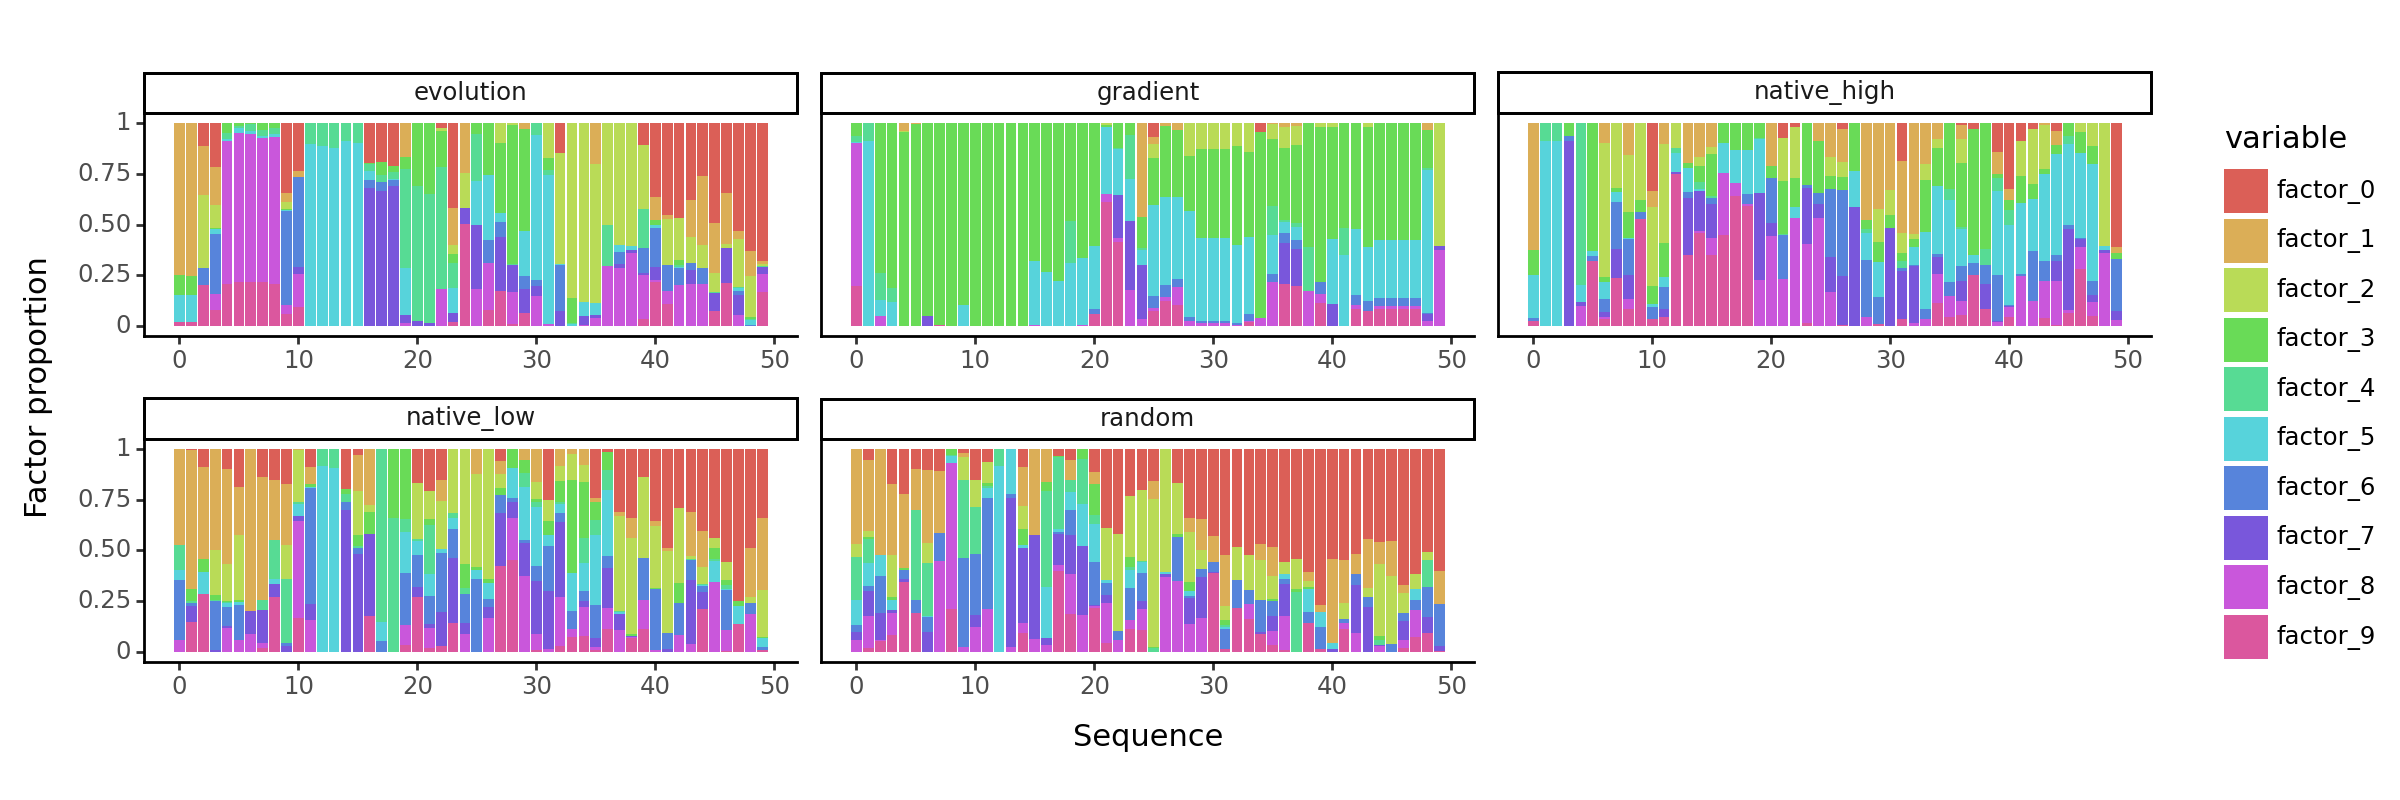

<Figure Size: (1200 x 400)>

In [51]:
polygraph.visualize.plot_seqs_nmf(W) + p9.theme(figure_size=(12, 4))

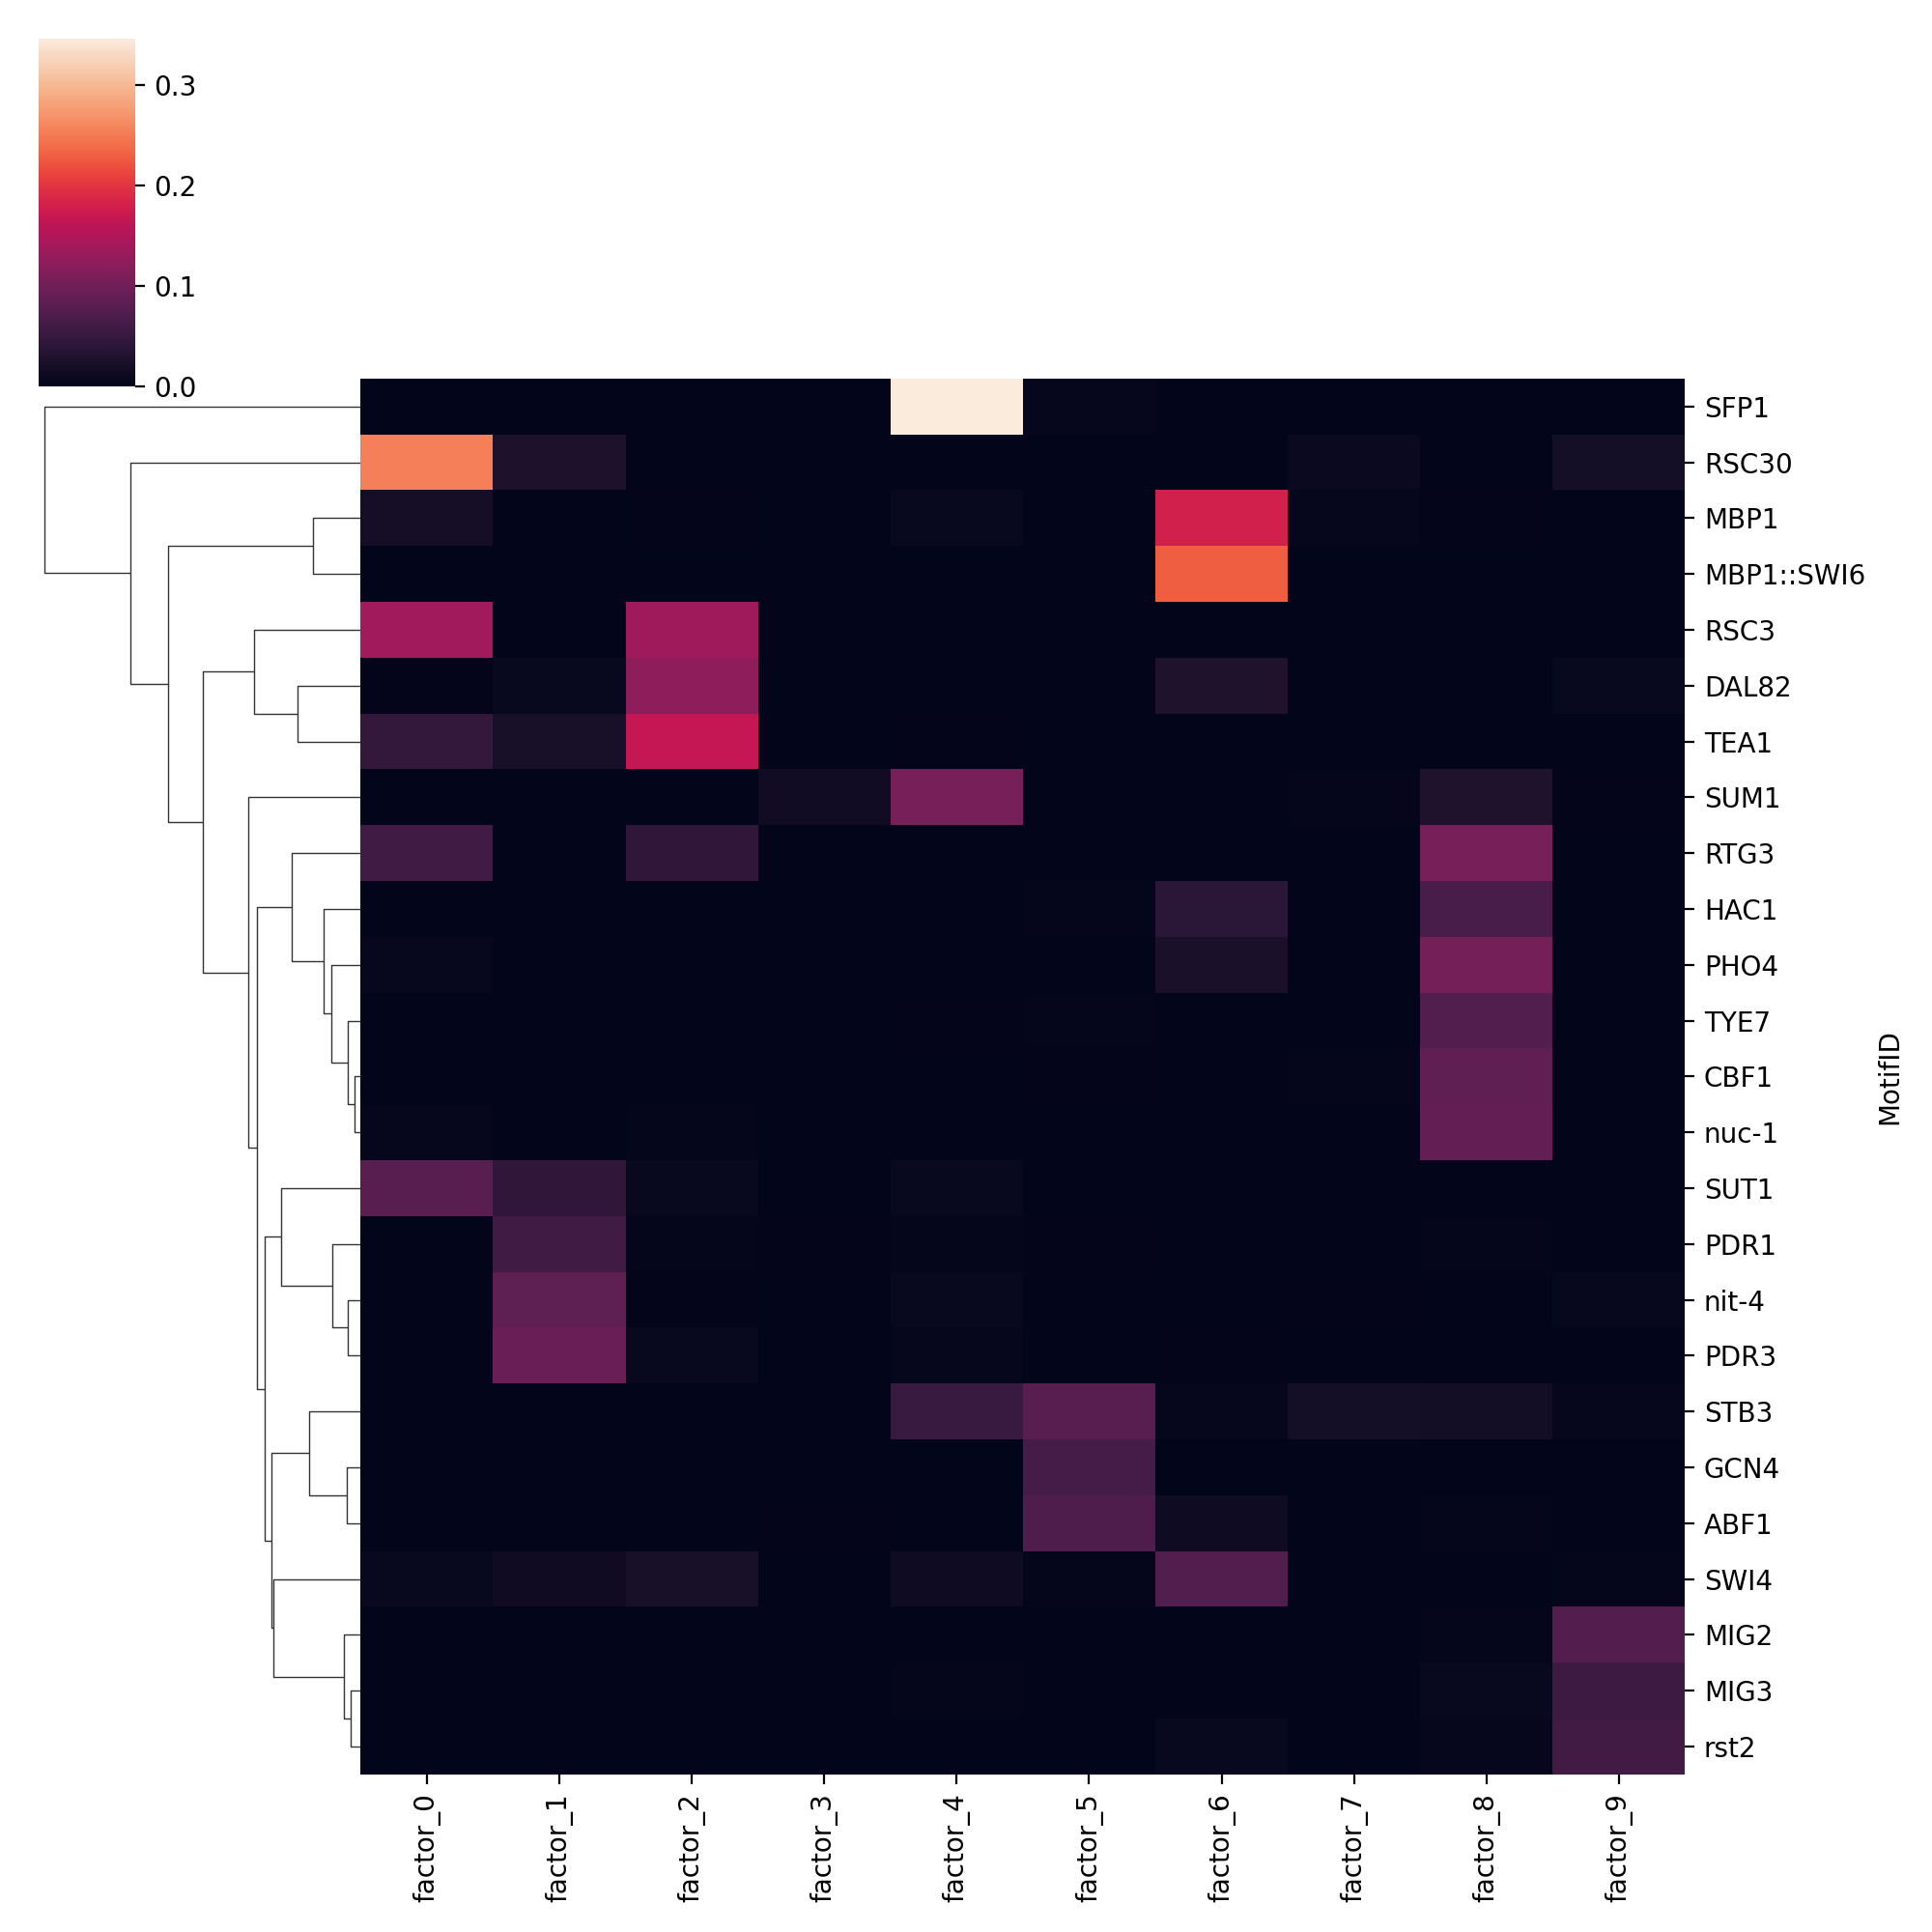

In [52]:
polygraph.visualize.plot_factors_nmf(H, n_features=25)

# 3. Model predictions

## 3.1 predictions

In [53]:
# Download yeast sequence-to-promoter activity model
!wget https://zenodo.org/records/10214625/files/yeast-model.pth

--2024-01-24 20:17:39--  https://zenodo.org/records/10214625/files/yeast-model.pth
Resolving zenodo.org (zenodo.org)... 188.185.79.172, 188.184.98.238, 188.184.103.159, ...
Connecting to zenodo.org (zenodo.org)|188.185.79.172|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9968513 (9.5M) [application/octet-stream]
Saving to: ‘yeast-model.pth.1’

yeast-model.pth.1   100%[===================>]   9.51M  5.86MB/s    in 1.6s    

2024-01-24 20:17:43 (5.86 MB/s) - ‘yeast-model.pth.1’ saved [9968513/9968513]



In [54]:
import torch
model = torch.load('yeast-model.pth')

In [55]:
seqs[['complex_pred', 'defined_pred']] = polygraph.models.predict(model, seqs, batch_size=512)

Padding all sequences to length 80


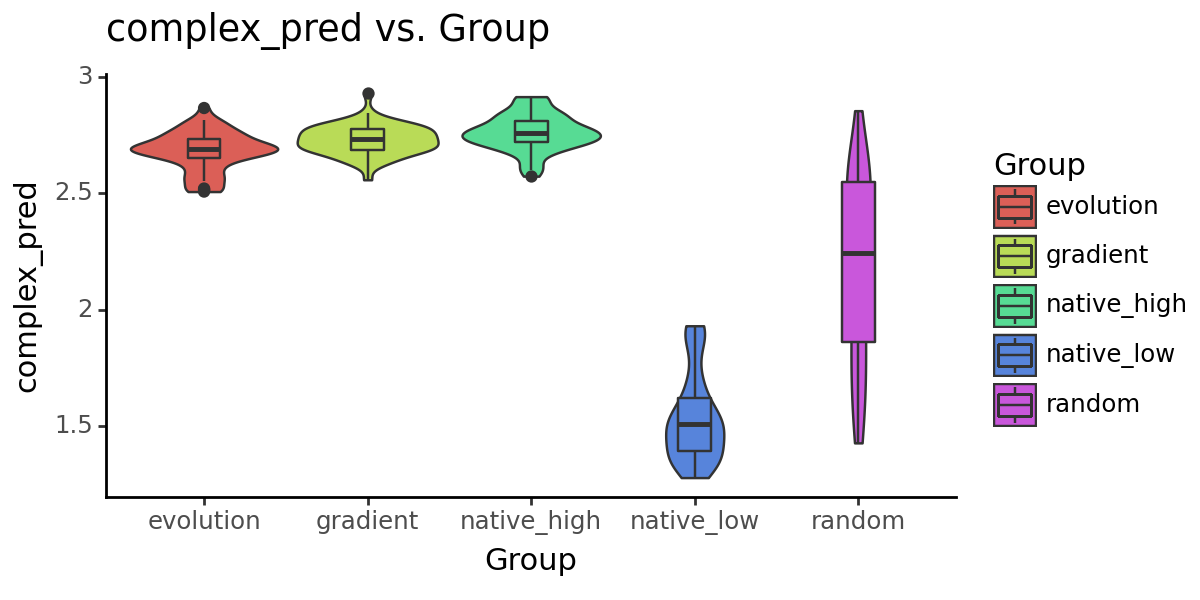

<Figure Size: (600 x 300)>

In [56]:
polygraph.visualize.boxplot(seqs, value_col='complex_pred') + p9.theme(figure_size=(6, 3))

## 3.2 cell type specificity

In [57]:
seqs[['mingap', 'meangap', 'maxgap']] = polygraph.models.cell_type_specificity(seqs.complex_pred, [seqs.defined_pred])

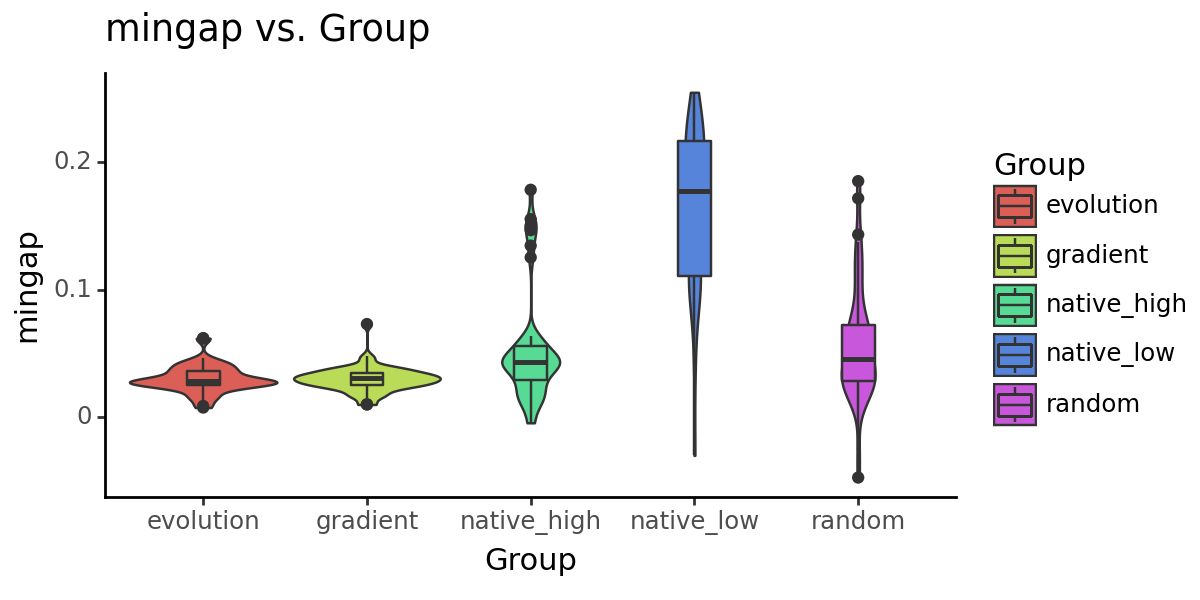

<Figure Size: (600 x 300)>

In [58]:
polygraph.visualize.boxplot(seqs, value_col='mingap') + p9.theme(figure_size=(6, 3))

## 3.3 Model embeddings

In [59]:
%%time
emb = polygraph.models.get_embeddings(seqs, model, batch_size=512, drop_last_layers=4)

Padding all sequences to length 80
CPU times: user 7.74 s, sys: 278 ms, total: 8.02 s
Wall time: 73 ms


In [60]:
emb = polygraph.embedding.embedding_analysis(emb, seqs, reference_group='native_high')

Creating AnnData object
PCA
Fraction of variance explained:  [0.79 0.06 0.04 0.02 0.01 0.01 0.01 0.01 0.01 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Fraction of total variance explained:  0.9960335
UMAP


/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


Differential feature abundance
1-NN statistics
Within-group KNN diversity
Euclidean distance to nearest reference


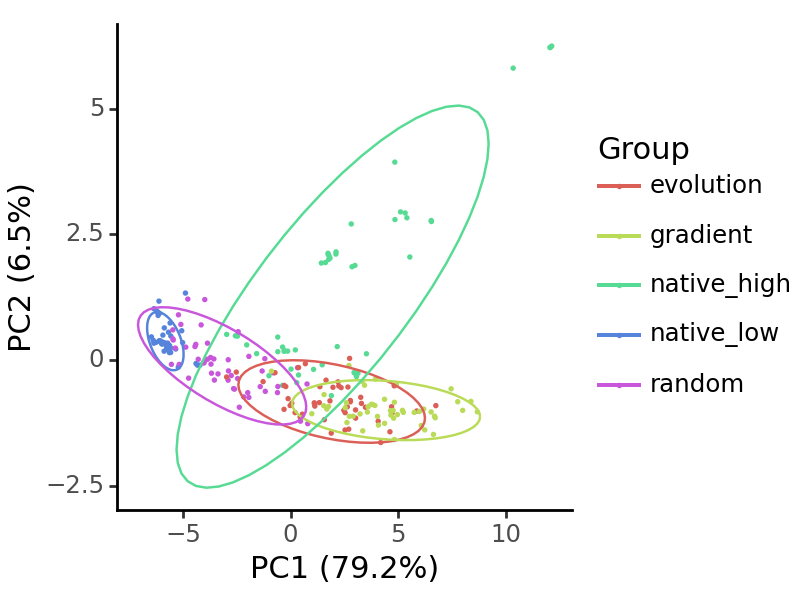

<Figure Size: (400 x 300)>

In [61]:
polygraph.visualize.pca_plot(emb) + p9.theme(figure_size=(4, 3))

one_nn_group  evolution  gradient  native_high  native_low  random
Group                                                             
evolution          0.46      0.42         0.02        0.00    0.10
gradient           0.38      0.60         0.00        0.00    0.02
native_high        0.10      0.02         0.86        0.00    0.02
native_low         0.00      0.00         0.00        0.88    0.12
random             0.20      0.06         0.00        0.14    0.60
            group_prop  ref_prop      pval      padj
Group                                               
native_low        0.00      0.86  5.24e-21  6.99e-21
random            0.00      0.86  5.24e-21  6.99e-21
evolution         0.02      0.86  2.03e-19  2.03e-19
gradient          0.00      0.86  5.24e-21  6.99e-21


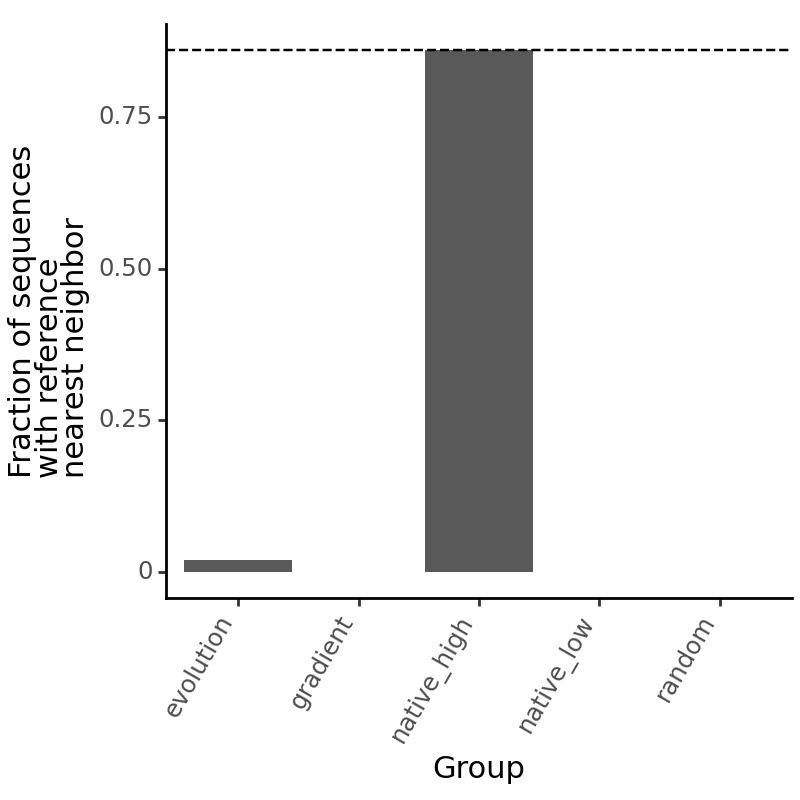

<Figure Size: (400 x 400)>

In [63]:
# 1-NN statistics
print(emb.uns["1NN_group_probs"])
print(emb.uns["1NN_ref_prop_test"])
polygraph.visualize.one_nn_frac_plot(emb, reference_group="native_high") + p9.theme(figure_size=(4,4))

{'Kruskal': 2.348966769780271e-33, 'Dunn':              evolution  gradient  native_high  native_low    random
evolution     1.00e+00  8.49e-04     1.04e-04    3.98e-13  8.69e-01
gradient      8.49e-04  1.00e+00     7.51e-16    2.82e-03  2.65e-01
native_high   1.04e-04  7.51e-16     1.00e+00    5.09e-32  9.32e-09
native_low    3.98e-13  2.82e-03     5.09e-32    1.00e+00  4.93e-08
random        8.69e-01  2.65e-01     9.32e-09    4.93e-08  1.00e+00}


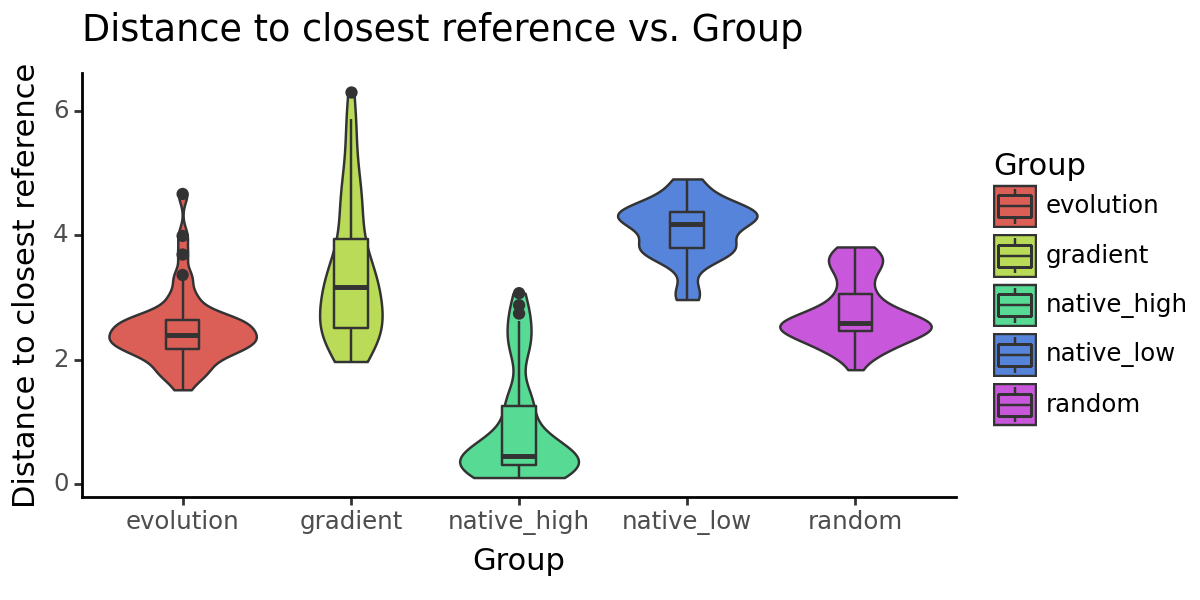

<Figure Size: (600 x 300)>

In [64]:
#Distance to reference
print(emb.uns['ref_dist_test'])

polygraph.visualize.boxplot(emb.obs, value_col='Distance to closest reference') + p9.theme(figure_size=(6, 3))

{'Kruskal': 1.0994738008634255e-24, 'Dunn':              evolution  gradient  native_high  native_low    random
evolution     1.00e+00  8.17e-01     1.12e-02    3.28e-12  1.00e+00
gradient      8.17e-01  1.00e+00     5.76e-06    3.00e-07  1.00e+00
native_high   1.12e-02  5.76e-06     1.00e+00    5.63e-25  2.73e-03
native_low    3.28e-12  3.00e-07     5.63e-25    1.00e+00  5.18e-11
random        1.00e+00  1.00e+00     2.73e-03    5.18e-11  1.00e+00}


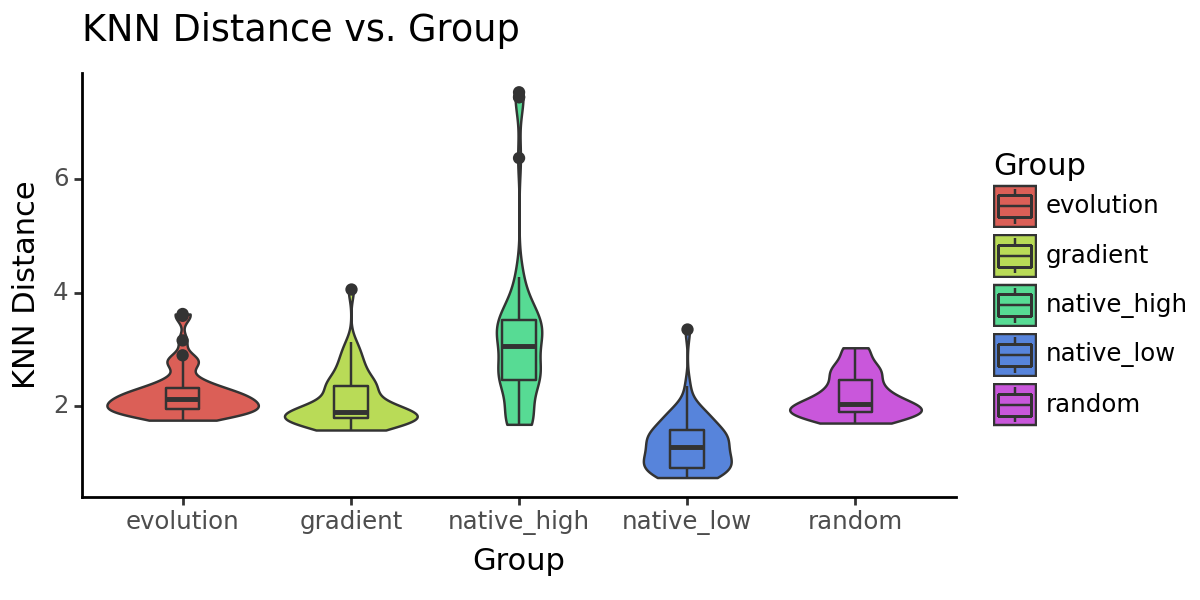

<Figure Size: (600 x 300)>

In [65]:
# KNN distance (diversity metric)
print(emb.uns['knn_dist_test'])
polygraph.visualize.boxplot(emb.obs, value_col='KNN Distance') + p9.theme(figure_size=(6,3))

## 3.4 edit distance to closest native sequence 

In [66]:
%%time
seqs['edit'] = polygraph.sequence.min_edit_distance_from_reference(seqs, reference_group='native_high')

CPU times: user 39.3 ms, sys: 0 ns, total: 39.3 ms
Wall time: 38.8 ms


{'Kruskal': 5.923511583752835e-28, 'Dunn':              evolution  gradient  native_high  native_low    random
evolution     1.00e+00  1.00e+00     6.81e-19    1.71e-01  1.00e+00
gradient      1.00e+00  1.00e+00     1.45e-21    2.47e-02  1.00e+00
native_high   6.81e-19  1.45e-21     1.00e+00    1.51e-10  7.34e-20
native_low    1.71e-01  2.47e-02     1.51e-10    1.00e+00  8.75e-02
random        1.00e+00  1.00e+00     7.34e-20    8.75e-02  1.00e+00}


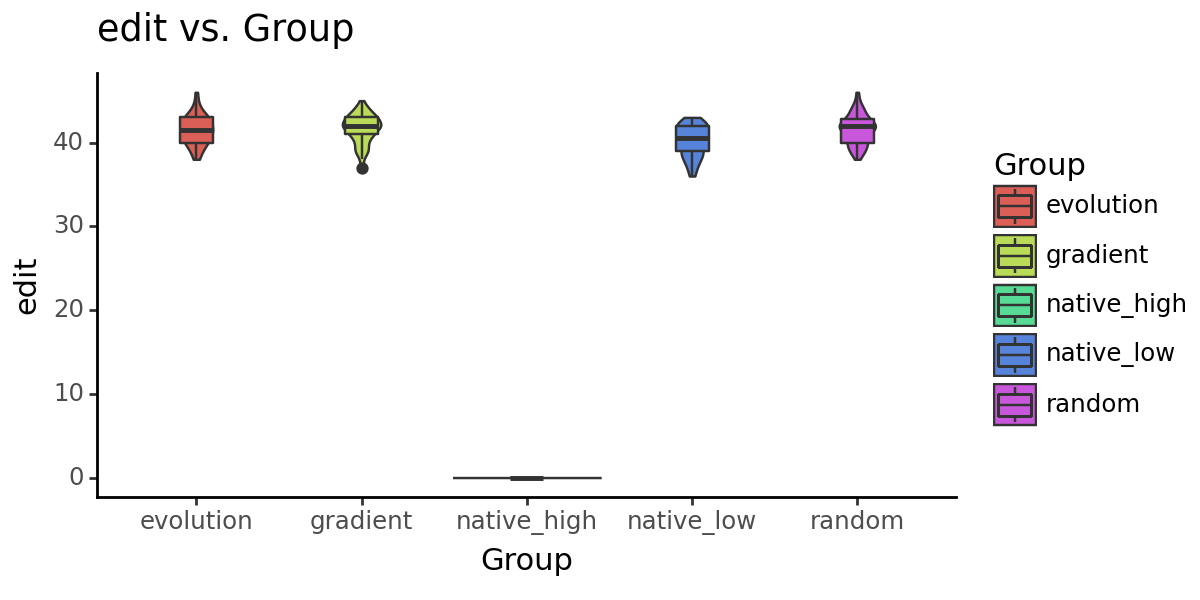

<Figure Size: (600 x 300)>

In [67]:
print(polygraph.stats.kruskal_dunn(seqs[seqs.Group!='native'], val_col='edit'))
polygraph.visualize.boxplot(seqs, value_col='edit') + p9.theme(figure_size=(6, 3))